In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
df_train = pd.read_csv('train.csv')
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,G

# Missing Data

In [3]:
df_missing = df_train.isnull().sum()

In [4]:
df_missing = df_missing.sort_values(ascending=False)

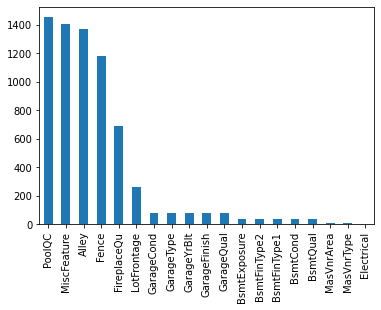

In [5]:
df_missing[df_missing > 0].plot.bar()

In [6]:
df_missing = df_missing[df_missing > 0]

In [7]:
len(df_missing)

19

In [8]:
df_train = df_train.drop(df_missing.index.tolist(), axis=1)

In [9]:
df_train

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,706,0,150,856,GasA,Ex,Y,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,2,548,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,978,0,284,1262,GasA,Ex,Y,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,2,460,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,486,0,434,920,GasA,Ex,Y,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,2,608,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,BrkTil,216,0,540,756,GasA,Gd,Y,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,3,642,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,655,0,490,1145,GasA,Ex,Y,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,3,836,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,0,0,953,953,GasA,Ex,Y,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,2,460,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,TA,TA,CBlock,790,163,589,1542,GasA,TA,Y,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,2,500,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,Ex,Gd,Stone,275,0,877,1152,GasA,Ex,Y,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,1,252,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,TA,TA,CBlock,49,1029,0,1078,GasA,Gd,Y,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,1,240,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125


In [10]:
df_train.isnull().sum().max()

0

In [11]:
numeric = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
numeric.remove('Id')
numeric.remove('SalePrice')

categorical = [f for f in df_train.columns if df_train.dtypes[f] == 'object']

# **Categorical Data**

In [12]:
category_maps = []
def add_rank_feature(feature_name, rank_feature_name):
  df_order = pd.DataFrame()
  df_order['val'] = df_train[feature_name].unique()
  df_order.index = df_order.val

  df_order['mean_price'] = df_train[[feature_name, 'SalePrice']].groupby(feature_name).mean()['SalePrice']
  df_order['rank'] = range(1, len(df_order) + 1)
  df_order = df_order['rank'].to_dict()

  category_maps.append(df_order)

  df_train[rank_feature_name] = df_train.apply(lambda x: df_order[x[feature_name]], axis=1)

In [13]:
rank_features = []
for feature_name in categorical:

  rank_feature_name = feature_name + '_rank'

  print(feature_name, '-->', rank_feature_name)

  add_rank_feature(feature_name, rank_feature_name)

  rank_features.append(rank_feature_name)

MSZoning --> MSZoning_rank
Street --> Street_rank
LotShape --> LotShape_rank
LandContour --> LandContour_rank
Utilities --> Utilities_rank
LotConfig --> LotConfig_rank
LandSlope --> LandSlope_rank
Neighborhood --> Neighborhood_rank
Condition1 --> Condition1_rank
Condition2 --> Condition2_rank
BldgType --> BldgType_rank
HouseStyle --> HouseStyle_rank
RoofStyle --> RoofStyle_rank
RoofMatl --> RoofMatl_rank
Exterior1st --> Exterior1st_rank
Exterior2nd --> Exterior2nd_rank
ExterQual --> ExterQual_rank
ExterCond --> ExterCond_rank
Foundation --> Foundation_rank
Heating --> Heating_rank
HeatingQC --> HeatingQC_rank
CentralAir --> CentralAir_rank
KitchenQual --> KitchenQual_rank
Functional --> Functional_rank
PavedDrive --> PavedDrive_rank
SaleType --> SaleType_rank
SaleCondition --> SaleCondition_rank


In [14]:
df_processed = df_train[rank_features + numeric]

In [15]:
df_processed

,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterQual_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008
1,1,1,1,1,1,2,1,2,2,1,1,2,1,1,2,2,2,1,2,1,1,1,2,1,1,1,1,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007
2,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008
3,1,1,2,1,1,3,1,3,1,1,1,1,1,1,3,3,2,1,3,1,2,1,1,1,1,1,2,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006
4,1,1,2,1,1,2,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1,1,1,1,1,1,1,18,1,1,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,1,1,60,7917,6,5,1999,2000,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,2,460,0,40,0,0,0,0,0,8,2007
1456,1,1,1,1,1,1,1,7,1,1,1,2,1,1,8,5,2,1,2,1,3,1,2,2,1,1,1,20,13175,6,6,1978,1988,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,2,500,349,0,0,0,0,0,0,2,2010
1457,1,1,1,1,1,1,1,3,1,1,1,1,1,1,7,7,3,2,6,1,1,1,1,1,1,1,1,70,9042,7,9,1941,2006,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1,252,0,60,0,0,0,0,2500,5,2010
1458,1,1,1,1,1,1,1,12,1,1,1,2,2,1,2,2,2,1,2,1,2,1,1,1,1,1,1,20,9717,5,6,1950,1996,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1,240,366,0,112,0,0,0,0,4,2010


In [16]:
df_processed['SalePrice'] = df_train['SalePrice']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
corrmat = df_processed.corr()

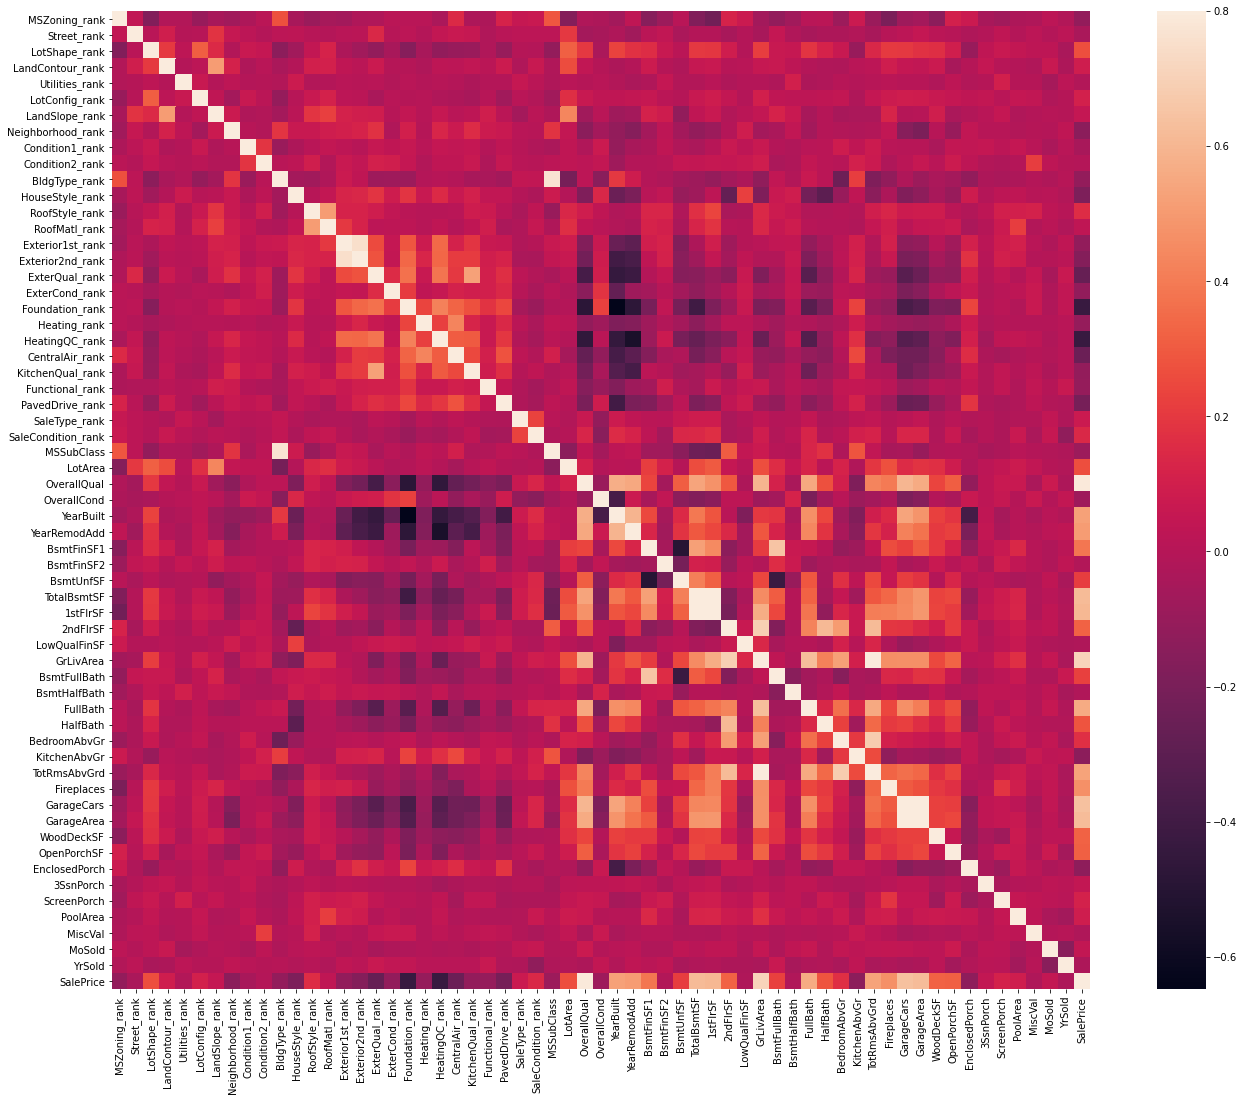

In [18]:
f, ax = plt.subplots(figsize=(24, 18))
sns.heatmap(corrmat, vmax=.8, square=True)

In [19]:
df_features = corrmat.sort_values(by=['SalePrice'])['SalePrice']

In [20]:
df_features[-40:]

YrSold               -0.028923
LowQualFinSF         -0.025606
MiscVal              -0.021190
BsmtHalfBath         -0.016844
Utilities_rank       -0.014314
BsmtFinSF2           -0.011378
Condition2_rank      -0.004833
RoofMatl_rank         0.035820
3SsnPorch             0.044584
MoSold                0.046432
LandSlope_rank        0.051152
SaleType_rank         0.072896
LandContour_rank      0.092009
PoolArea              0.092404
LotConfig_rank        0.109106
ScreenPorch           0.111447
SaleCondition_rank    0.142503
RoofStyle_rank        0.159332
BedroomAbvGr          0.168213
BsmtUnfSF             0.214479
BsmtFullBath          0.227122
LotArea               0.263843
LotShape_rank         0.267759
HalfBath              0.284108
OpenPorchSF           0.315856
2ndFlrSF              0.319334
WoodDeckSF            0.324413
BsmtFinSF1            0.386420
Fireplaces            0.466929
YearRemodAdd          0.507101
YearBuilt             0.522897
TotRmsAbvGrd          0.533723
FullBath

# X, Y data

In [21]:
NUM_FEATURES = len(df_features) - 1
print(NUM_FEATURES)

60


In [22]:
from sklearn.model_selection import train_test_split

In [23]:
x = df_processed[df_features[-NUM_FEATURES-1:-1].index.tolist()]
y = df_processed['SalePrice']

In [24]:
x

,Foundation_rank,HeatingQC_rank,ExterQual_rank,CentralAir_rank,PavedDrive_rank,HouseStyle_rank,Exterior2nd_rank,Neighborhood_rank,KitchenAbvGr,EnclosedPorch,ExterCond_rank,Exterior1st_rank,MSZoning_rank,KitchenQual_rank,BldgType_rank,Functional_rank,Heating_rank,MSSubClass,OverallCond,Condition1_rank,Street_rank,YrSold,LowQualFinSF,MiscVal,BsmtHalfBath,Utilities_rank,BsmtFinSF2,Condition2_rank,RoofMatl_rank,3SsnPorch,MoSold,LandSlope_rank,SaleType_rank,LandContour_rank,PoolArea,LotConfig_rank,ScreenPorch,SaleCondition_rank,RoofStyle_rank,BedroomAbvGr,BsmtUnfSF,BsmtFullBath,LotArea,LotShape_rank,HalfBath,OpenPorchSF,2ndFlrSF,WoodDeckSF,BsmtFinSF1,Fireplaces,YearRemodAdd,YearBuilt,TotRmsAbvGrd,FullBath,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual
0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,60,5,1,1,2008,0,0,0,1,0,1,1,0,2,1,1,1,0,1,0,1,1,3,150,1,8450,1,1,61,854,0,706,0,2003,2003,8,2,856,856,548,2,1710,7
1,2,1,2,1,1,2,2,2,1,0,1,2,1,2,1,1,1,20,8,2,1,2007,0,0,1,1,0,1,1,0,5,1,1,1,0,2,0,1,1,3,284,0,9600,1,0,0,0,298,978,1,1976,1976,6,2,1262,1262,460,2,1262,6
2,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,60,5,1,1,2008,0,0,0,1,0,1,1,0,9,1,1,1,0,1,0,1,1,3,434,1,11250,2,1,42,866,0,486,1,2002,2001,6,2,920,920,608,2,1786,7
3,3,2,2,1,1,1,3,3,1,272,1,3,1,1,1,1,1,70,5,1,1,2006,0,0,0,1,0,1,1,0,2,1,1,1,0,3,0,2,1,3,540,1,9550,2,0,35,756,0,216,1,1970,1915,7,1,961,756,642,3,1717,7
4,1,1,1,1,1,1,1,4,1,0,1,1,1,1,1,1,1,60,5,1,1,2008,0,0,0,1,0,1,1,0,12,1,1,1,0,2,0,1,1,4,490,1,14260,2,1,84,1053,192,655,1,2000,2000,9,2,1145,1145,836,3,2198,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1,1,2,1,1,1,1,18,1,0,1,1,1,2,1,1,1,60,5,1,1,2007,0,0,0,1,0,1,1,0,8,1,1,1,0,1,0,1,1,3,953,0,7917,1,1,40,694,0,0,1,2000,1999,7,2,953,953,460,2,1647,6
1456,2,3,2,1,1,2,5,7,1,0,1,8,1,2,1,2,1,20,6,1,1,2010,0,0,0,1,163,1,1,0,2,1,1,1,0,1,0,1,1,3,589,1,13175,1,0,0,0,349,790,2,1988,1978,7,2,2073,1542,500,2,2073,6
1457,6,1,3,1,1,1,7,3,1,0,2,7,1,1,1,1,1,70,9,1,1,2010,0,2500,0,1,0,1,1,0,5,1,1,1,0,1,0,1,1,4,877,0,9042,1,0,60,1152,0,275,2,2006,1941,9,2,1188,1152,252,1,2340,7
1458,2,2,2,1,1,2,2,12,1,112,1,2,1,1,1,1,1,20,6,1,1,2010,0,0,0,1,1029,1,1,0,4,1,1,1,0,1,0,1,2,2,0,1,9717,1,0,0,0,366,49,0,1996,1950,5,1,1078,1078,240,1,1078,5


In [25]:
x['GrLivArea'].min(), x['GrLivArea'].max(), x['GrLivArea'].median()

(334, 5642, 1464.0)

In [26]:
y = np.array(y).reshape(-1, 1)

In [27]:
x.shape, y.shape

((1460, 60), (1460, 1))

In [29]:
x.to_csv('x.csv', index=False)

with open('x.npy', 'wb') as f:
  np.save(f, x)

with open('y.npy', 'wb') as f:
  np.save(f, y)

In [30]:
with open('x.npy', 'rb') as f:
  x = np.load(f)

with open('y.npy', 'rb') as f:
  y = np.load(f)

In [28]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.model_selection import KFold
x_min_max_scaler = MinMaxScaler()
x_min_max_scaler.fit(x)
scaled_x = x_min_max_scaler.transform(x)

y_min_max_scaler = MinMaxScaler()
y_min_max_scaler.fit(y)
scaled_y = y_min_max_scaler.transform(y)

In [ ]:
K = 10
kf = KFold(n_splits=K)

In [ ]:
import tensorflow as tf
from tensorflow import keras

# **Decision Trees**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as metrics

In [ ]:
rmses = []
for train_index, test_index in kf.split(scaled_x):
  scaled_x_train, scaled_x_test = scaled_x[train_index], scaled_x[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  model = DecisionTreeRegressor(random_state=0)
  model = model.fit(scaled_x_train, scaled_y_train)

  pred = model.predict(scaled_x_test).reshape((-1,1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print('--------------------')

  rmses.append(rmse)

print('average rmse: ', np.mean(rmses))

30399.757328562086
--------------------
39262.00048244564
--------------------
31348.02105259905
--------------------
45609.41761613818
--------------------
42668.42060694013
--------------------
34194.276779042724
--------------------
33546.08553058073
--------------------
35528.465214938704
--------------------
59407.585043958294
--------------------
37735.24464250168
--------------------
average rmse:  38969.92742977072


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rmses = []
for train_index, test_index in kf.split(scaled_x):
  scaled_x_train, scaled_x_test = scaled_x[train_index], scaled_x[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  model = RandomForestRegressor(random_state=0)
  model = model.fit(scaled_x_train, scaled_y_train)

  pred = model.predict(scaled_x_test).reshape((-1,1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print('--------------------')

  rmses.append(rmse)

print('average rmse: ', np.mean(rmses))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


25159.509083136116
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


27278.945783727027
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


22064.962825420196
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


40682.7576830191
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


32543.34638355806
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


26678.57878570247
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


24411.059545876644
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


23138.959475267948
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


43141.505098849804
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


26895.596395392888
--------------------
average rmse:  29199.52210599503


# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
rmses = []
for train_index, test_index in kf.split(scaled_x):
  scaled_x_train, scaled_x_test = scaled_x[train_index], scaled_x[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  model = AdaBoostRegressor(random_state=0)
  model = model.fit(scaled_x_train, scaled_y_train)

  pred = model.predict(scaled_x_test).reshape((-1,1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print('--------------------')

  rmses.append(rmse)

print('average rmse: ', np.mean(rmses))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


29216.343827541197
--------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


33282.117102484
--------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


29149.232825948846
--------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


44189.177644650124
--------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


39012.2510911128
--------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


33095.41790740461
--------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


31417.10861322294
--------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


30933.03236129543
--------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


46328.51256772787
--------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34212.22304763838
--------------------
average rmse:  35083.54169890263


# XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
rmses = []
for train_index, test_index in kf.split(scaled_x):
  scaled_x_train, scaled_x_test = scaled_x[train_index], scaled_x[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]

  y_test = y[test_index]

  model = XGBRegressor(n_estimators=300)
  model = model.fit(scaled_x_train, scaled_y_train)

  pred = model.predict(scaled_x_test).reshape((-1,1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print('--------------------')

  rmses.append(rmse)

print('average rmse: ', np.mean(rmses))

[12:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
20119.145009285483
--------------------
[12:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
23169.38252926395
--------------------
[12:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
21690.38435914477
--------------------
[12:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
39523.493638339394
--------------------
[12:40:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
29233.15572183937
--------------------
[12:40:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
23923.69793328054
--------------------
[1

# HyperParameter Tuning

# **Grid Search**

In [ ]:
batch_sizes = np.arange(5, 10, 2)

In [ ]:
learning_rates = [0.005, 0.01, 0.02]

In [ ]:
results=[]

for batch_size in batch_sizes:
  for learning_rate in learning_rates:
    print(batch_size, learning_rate)
    for train_index, test_index in kf.split(scaled_x):
      scaled_x_train, scaled_x_test = scaled_x[train_index], scaled_x[test_index]
      scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
      y_test = y[test_index]

      model = keras.Sequential(
          [
            layers.InputLayer(input_shape=scaled_x_train.shape[-1]),
            layers.Dense(96, activation='relu'),
            layers.Dense(48, activation='relu'),
            layers.Dense(1)
          ]
      )

      opt = keras.optimizers.Adam(learning_rate=0.005)
      model.compile(loss='mse', optimizer=opt)

      early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
      model.fit(scaled_x_train, scaled_y_train,
                batch_size=1, epochs=150,
                callbacks=[early_stopping_callback], validation_split=0.05, verbose='auto')
      
      pred = model.predict(scaled_x_test).reshape((-1, 1))
      pred = y_min_max_scaler.inverse_transform(pred)
      rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

      print(rmse)
      print('--------------------')

      result={}
      result['batch_size'] = batch_size
      result['learning_rate'] = learning_rate
      result['rmse'] = rmse

      results .append(result)
      break

    break
  break

5 0.005
Epoch 1/150
1248/1248 [==============================] - 2s 2ms/step - loss: 0.0073 - val_loss: 0.0024
Epoch 2/150
1248/1248 [==============================] - 2s 1ms/step - loss: 0.0063 - val_loss: 0.0029
Epoch 3/150
1248/1248 [==============================] - 2s 1ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 4/150
1248/1248 [==============================] - 2s 1ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 5/150
1248/1248 [==============================] - 2s 1ms/step - loss: 0.0034 - val_loss: 0.0060
Epoch 6/150
1248/1248 [==============================] - 2s 1ms/step - loss: 0.0032 - val_loss: 0.0073
Epoch 7/150
1248/1248 [==============================] - 2s 1ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 8/150
1248/1248 [==============================] - 2s 1ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 9/150
1248/1248 [==============================] - 2s 1ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 10/150
1248/1248 [==============================] - 2s 1ms/

In [ ]:
results

[{'batch_size': 5, 'learning_rate': 0.005, 'rmse': 27975.572696614192}]

In [ ]:
import random

In [ ]:
batch_sizes = random.sample(range(1, 11), 5)

In [ ]:
batch_sizes

[9, 8, 7, 4, 5]

In [ ]:
learning_rates = np.random.uniform(low=0.005, high=0.1, size=(4,))

In [ ]:
learning_rates

array([0.04682328, 0.0668997 , 0.0113784 , 0.01694841])

# Submission

In [ ]:
df_test = pd.read_csv('test.csv')

In [ ]:
df_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,Comp

In [ ]:
df_missing

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [ ]:
df_test = df_test.drop(df_missing.index.tolist(), axis=1)

In [ ]:
df_test.shape

(1459, 61)

In [ ]:
df_test.isnull().sum()

Id               0
MSSubClass       0
MSZoning         4
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         1
SaleCondition    0
Length: 61, dtype: int64

In [ ]:
category_maps

[{'C (all)': 3, 'FV': 4, 'RH': 5, 'RL': 1, 'RM': 2},
 {'Grvl': 2, 'Pave': 1},
 {'IR1': 2, 'IR2': 3, 'IR3': 4, 'Reg': 1},
 {'Bnk': 2, 'HLS': 4, 'Low': 3, 'Lvl': 1},
 {'AllPub': 1, 'NoSeWa': 2},
 {'Corner': 3, 'CulDSac': 4, 'FR2': 2, 'FR3': 5, 'Inside': 1},
 {'Gtl': 1, 'Mod': 2, 'Sev': 3},
 {'Blmngtn': 22,
  'Blueste': 25,
  'BrDale': 23,
  'BrkSide': 9,
  'ClearCr': 20,
  'CollgCr': 1,
  'Crawfor': 3,
  'Edwards': 16,
  'Gilbert': 18,
  'IDOTRR': 14,
  'MeadowV': 15,
  'Mitchel': 5,
  'NAmes': 12,
  'NPkVill': 21,
  'NWAmes': 7,
  'NoRidge': 4,
  'NridgHt': 11,
  'OldTown': 8,
  'SWISU': 24,
  'Sawyer': 10,
  'SawyerW': 13,
  'Somerst': 6,
  'StoneBr': 19,
  'Timber': 17,
  'Veenker': 2},
 {'Artery': 4,
  'Feedr': 2,
  'Norm': 1,
  'PosA': 8,
  'PosN': 3,
  'RRAe': 5,
  'RRAn': 7,
  'RRNe': 9,
  'RRNn': 6},
 {'Artery': 2,
  'Feedr': 4,
  'Norm': 1,
  'PosA': 6,
  'PosN': 5,
  'RRAe': 8,
  'RRAn': 7,
  'RRNn': 3},
 {'1Fam': 1, '2fmCon': 2, 'Duplex': 3, 'Twnhs': 5, 'TwnhsE': 4},
 {'1.5Fin

In [ ]:
def category_to_number(x, category_map, feature_name):
  if x[feature_name] in category_map:
    return category_map[x[feature_name]]
  else:
    0

In [ ]:
for i, feature_name in enumerate(categorical):
  rank_feature_name = feature_name + '_rank'
  print(feature_name, '-->', rank_feature_name)

  category_map = category_maps[i]
  print(category_map)
 
  df_test[rank_feature_name] = df_test.apply(lambda x: category_to_number(x, category_map, feature_name), axis=1)

MSZoning --> MSZoning_rank
{'RL': 1, 'RM': 2, 'C (all)': 3, 'FV': 4, 'RH': 5}
Street --> Street_rank
{'Pave': 1, 'Grvl': 2}
LotShape --> LotShape_rank
{'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4}
LandContour --> LandContour_rank
{'Lvl': 1, 'Bnk': 2, 'Low': 3, 'HLS': 4}
Utilities --> Utilities_rank
{'AllPub': 1, 'NoSeWa': 2}
LotConfig --> LotConfig_rank
{'Inside': 1, 'FR2': 2, 'Corner': 3, 'CulDSac': 4, 'FR3': 5}
LandSlope --> LandSlope_rank
{'Gtl': 1, 'Mod': 2, 'Sev': 3}
Neighborhood --> Neighborhood_rank
{'CollgCr': 1, 'Veenker': 2, 'Crawfor': 3, 'NoRidge': 4, 'Mitchel': 5, 'Somerst': 6, 'NWAmes': 7, 'OldTown': 8, 'BrkSide': 9, 'Sawyer': 10, 'NridgHt': 11, 'NAmes': 12, 'SawyerW': 13, 'IDOTRR': 14, 'MeadowV': 15, 'Edwards': 16, 'Timber': 17, 'Gilbert': 18, 'StoneBr': 19, 'ClearCr': 20, 'NPkVill': 21, 'Blmngtn': 22, 'BrDale': 23, 'SWISU': 24, 'Blueste': 25}
Condition1 --> Condition1_rank
{'Norm': 1, 'Feedr': 2, 'PosN': 3, 'Artery': 4, 'RRAe': 5, 'RRNn': 6, 'RRAn': 7, 'PosA': 8, 'RRNe': 9}
C

In [ ]:
df_test

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,...,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterQual_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank
0,1461,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,TA,TA,CBlock,468.0,144.0,270.0,882.0,GasA,TA,Y,896,0,0,896,0.0,0.0,1,...,730.0,Y,140,0,0,0,120,0,0,6,2010,WD,Normal,5.0,1,1,1,1.0,1,1,12,2,1,1,2,1,1,1.0,1.0,2,1,2,1,3,1,2.0,1.0,1,1.0,1
1,1462,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,TA,TA,CBlock,923.0,0.0,406.0,1329.0,GasA,TA,Y,1329,0,0,1329,0.0,0.0,1,...,312.0,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal,1.0,1,2,1,1.0,3,1,12,1,1,1,2,2,1,3.0,6.0,2,1,2,1,3,1,1.0,1.0,1,1.0,1
2,1463,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,791.0,0.0,137.0,928.0,GasA,Gd,Y,928,701,0,1629,0.0,0.0,2,...,482.0,Y,212,34,0,0,0,0,0,3,2010,WD,Normal,1.0,1,2,1,1.0,1,1,18,1,1,1,1,1,1,1.0,1.0,2,1,1,1,2,1,2.0,1.0,1,1.0,1
3,1464,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,602.0,0.0,324.0,926.0,GasA,Ex,Y,926,678,0,1604,0.0,0.0,2,...,470.0,Y,360,36,0,0,0,0,0,6,2010,WD,Normal,1.0,1,2,1,1.0,1,1,18,1,1,1,1,1,1,1.0,1.0,2,1,1,1,1,1,1.0,1.0,1,1.0,1
4,1465,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,Gd,TA,PConc,263.0,0.0,1017.0,1280.0,GasA,Ex,Y,1280,0,0,1280,0.0,0.0,2,...,506.0,Y,0,82,0,0,144,0,0,1,2010,WD,Normal,1.0,1,2,4,1.0,1,1,19,1,1,4,2,1,1,4.0,4.0,1,1,1,1,1,1,1.0,1.0,1,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,TA,TA,CBlock,0.0,0.0,546.0,546.0,GasA,Gd,Y,546,546,0,1092,0.0,0.0,1,...,0.0,Y,0,0,0,0,0,0,0,6,2006,WD,Normal,2.0,1,1,1,1.0,1,1,15,1,1,5,1,1,1,7.0,7.0,2,1,2,1,2,1,2.0,1.0,1,1.0,1
1455,2916,160,RM,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,TA,TA,CBlock,252.0,0.0,294.0,546.0,GasA,TA,Y,546,546,0,1092,0.0,0.0,1,...,286.0,Y,0,24,0,0,0,0,0,4,2006,WD,Abnorml,2.0,1,1,1,1.0,1,1,15,1,1,4,1,1,1,7.0,7.0,2,1,2,1,3,1,2.0,1.0,1,1.0,2
1456,2917,20,RL,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,TA,TA,CBlock,1224.0,0.0,0.0,1224.0,GasA,Ex,Y,1224,0,0,1224,1.0,0.0,1,...,576.0,Y,474,0,0,0,0,0,0,9,2006,WD,Abnorml,1.0,1,1,1,1.0,1,1,5,1,1,1,2,1,1,1.0,1.0,2,1,2,1,1,1,2.0,1.0,1,1.0,2
1457,2918,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,TA,TA,PConc,337.0,0.0,575.0,912.0,GasA,TA,Y,970,0,0,970,0.0,1.0,1,...,0.0,Y,80,32,0,0,0,0,700,7,2006,W

In [ ]:
df_processed_test = df_test[rank_features + numeric]

In [ ]:
df_processed_test

,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterQual_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,5.0,1,1,1,1.0,1,1,12,2,1,1,2,1,1,1.0,1.0,2,1,2,1,3,1,2.0,1.0,1,1.0,1,20,11622,5,6,1961,1961,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,6,2010
1,1.0,1,2,1,1.0,3,1,12,1,1,1,2,2,1,3.0,6.0,2,1,2,1,3,1,1.0,1.0,1,1.0,1,20,14267,6,6,1958,1958,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,6,2010
2,1.0,1,2,1,1.0,1,1,18,1,1,1,1,1,1,1.0,1.0,2,1,1,1,2,1,2.0,1.0,1,1.0,1,60,13830,5,5,1997,1998,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,3,2010
3,1.0,1,2,1,1.0,1,1,18,1,1,1,1,1,1,1.0,1.0,2,1,1,1,1,1,1.0,1.0,1,1.0,1,60,9978,6,6,1998,1998,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,2.0,470.0,360,36,0,0,0,0,0,6,2010
4,1.0,1,2,4,1.0,1,1,19,1,1,4,2,1,1,4.0,4.0,1,1,1,1,1,1,1.0,1.0,1,1.0,1,120,5005,8,5,1992,1992,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,2.0,506.0,0,82,0,0,144,0,0,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.0,1,1,1,1.0,1,1,15,1,1,5,1,1,1,7.0,7.0,2,1,2,1,2,1,2.0,1.0,1,1.0,1,160,1936,4,7,1970,1970,0.0,0.0,546.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,5,0,0.0,0.0,0,0,0,0,0,0,0,6,2006
1455,2.0,1,1,1,1.0,1,1,15,1,1,4,1,1,1,7.0,7.0,2,1,2,1,3,1,2.0,1.0,1,1.0,2,160,1894,4,5,1970,1970,252.0,0.0,294.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,6,0,1.0,286.0,0,24,0,0,0,0,0,4,2006
1456,1.0,1,1,1,1.0,1,1,5,1,1,1,2,1,1,1.0,1.0,2,1,2,1,1,1,2.0,1.0,1,1.0,2,20,20000,5,7,1960,1996,1224.0,0.0,0.0,1224.0,1224,0,0,1224,1.0,0.0,1,0,4,1,7,1,2.0,576.0,474,0,0,0,0,0,0,9,2006
1457,1.0,1,1,1,1.0,1,1,5,1,1,1,5,1,1,4.0,3.0,2,1,1,1,3,1,2.0,1.0,1,1.0,1,85,10441,5,5,1992,1992,337.0,0.0,575.0,912.0,970,0,0,970,0.0,1.0,1,0,3,1,6,0,0.0,0.0,80,32,0,0,0,0,700,7,2006


In [ ]:
df_processed_test = df_processed_test[df_features[-NUM_FEATURES-1:-1].index.tolist()]

In [ ]:
df_processed

,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterQual_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,1,1,1,1,1,2,1,2,2,1,1,2,1,1,2,2,2,1,2,1,1,1,2,1,1,1,1,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007,181500
2,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,223500
3,1,1,2,1,1,3,1,3,1,1,1,1,1,1,3,3,2,1,3,1,2,1,1,1,1,1,2,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006,140000
4,1,1,2,1,1,2,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1,1,1,1,1,1,1,18,1,1,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,1,1,60,7917,6,5,1999,2000,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,2,460,0,40,0,0,0,0,0,8,2007,175000
1456,1,1,1,1,1,1,1,7,1,1,1,2,1,1,8,5,2,1,2,1,3,1,2,2,1,1,1,20,13175,6,6,1978,1988,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,2,500,349,0,0,0,0,0,0,2,2010,210000
1457,1,1,1,1,1,1,1,3,1,1,1,1,1,1,7,7,3,2,6,1,1,1,1,1,1,1,1,70,9042,7,9,1941,2006,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1,252,0,60,0,0,0,0,2500,5,2010,266500
1458,1,1,1,1,1,1,1,12,1,1,1,2,2,1,2,2,2,1,2,1,2,1,1,1,1,1,1,20,9717,5,6,1950,1996,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1,240,366,0,112,0,0,0,0,4,2010,142125


In [ ]:
df_processed_test

,Foundation_rank,HeatingQC_rank,ExterQual_rank,CentralAir_rank,PavedDrive_rank,HouseStyle_rank,Exterior2nd_rank,Neighborhood_rank,KitchenAbvGr,EnclosedPorch,ExterCond_rank,Exterior1st_rank,MSZoning_rank,KitchenQual_rank,BldgType_rank,Functional_rank,Heating_rank,MSSubClass,OverallCond,Condition1_rank,Street_rank,YrSold,LowQualFinSF,MiscVal,BsmtHalfBath,Utilities_rank,BsmtFinSF2,Condition2_rank,RoofMatl_rank,3SsnPorch,MoSold,LandSlope_rank,SaleType_rank,LandContour_rank,PoolArea,LotConfig_rank,ScreenPorch,SaleCondition_rank,RoofStyle_rank,BedroomAbvGr,BsmtUnfSF,BsmtFullBath,LotArea,LotShape_rank,HalfBath,OpenPorchSF,2ndFlrSF,WoodDeckSF,BsmtFinSF1,Fireplaces,YearRemodAdd,YearBuilt,TotRmsAbvGrd,FullBath,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual
0,2,3,2,1,1,2,1.0,12,1,0,1,1.0,5.0,2.0,1,1.0,1,20,6,2,1,2010,0,0,0.0,1.0,144.0,1,1,0,6,1,1.0,1,0,1,120,1,1,2,270.0,0.0,11622,1,0,0,0,140,468.0,0,1961,1961,5,1,896,882.0,730.0,1.0,896,5
1,2,3,2,1,1,2,6.0,12,1,0,1,3.0,1.0,1.0,1,1.0,1,20,6,1,1,2010,0,12500,0.0,1.0,0.0,1,1,0,6,1,1.0,1,0,3,0,1,2,3,406.0,0.0,14267,2,1,36,0,393,923.0,0,1958,1958,6,1,1329,1329.0,312.0,1.0,1329,6
2,1,2,2,1,1,1,1.0,18,1,0,1,1.0,1.0,2.0,1,1.0,1,60,5,1,1,2010,0,0,0.0,1.0,0.0,1,1,0,3,1,1.0,1,0,1,0,1,1,3,137.0,0.0,13830,2,1,34,701,212,791.0,1,1998,1997,6,2,928,928.0,482.0,2.0,1629,5
3,1,1,2,1,1,1,1.0,18,1,0,1,1.0,1.0,1.0,1,1.0,1,60,6,1,1,2010,0,0,0.0,1.0,0.0,1,1,0,6,1,1.0,1,0,1,0,1,1,3,324.0,0.0,9978,2,1,36,678,360,602.0,1,1998,1998,7,2,926,926.0,470.0,2.0,1604,6
4,1,1,1,1,1,2,4.0,19,1,0,1,4.0,1.0,1.0,4,1.0,1,120,5,1,1,2010,0,0,0.0,1.0,0.0,1,1,0,1,1,1.0,4,0,1,144,1,1,2,1017.0,0.0,5005,2,0,82,0,0,263.0,0,1992,1992,5,2,1280,1280.0,506.0,2.0,1280,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2,2,2,1,1,1,7.0,15,1,0,1,7.0,2.0,2.0,5,1.0,1,160,7,1,1,2006,0,0,0.0,1.0,0.0,1,1,0,6,1,1.0,1,0,1,0,1,1,3,546.0,0.0,1936,1,1,0,546,0,0.0,0,1970,1970,5,1,546,546.0,0.0,0.0,1092,4
1455,2,3,2,1,1,1,7.0,15,1,0,1,7.0,2.0,2.0,4,1.0,1,160,5,1,1,2006,0,0,0.0,1.0,0.0,1,1,0,4,1,1.0,1,0,1,0,2,1,3,294.0,0.0,1894,1,1,24,546,0,252.0,0,1970,1970,6,1,546,546.0,286.0,1.0,1092,4
1456,2,1,2,1,1,2,1.0,5,1,0,1,1.0,1.0,2.0,1,1.0,1,20,7,1,1,2006,0,0,0.0,1.0,0.0,1,1,0,9,1,1.0,1,0,1,0,2,1,4,0.0,1.0,20000,1,0,0,0,474,1224.0,1,1996,1960,7,1,1224,1224.0,576.0,2.0,1224,5
1457,1,3,2,1,1,5,3.0,5,1,0,1,4.0,1.0,2.0,1,1.0,1,85,5,1,1,2006,0,700,1.0,1.0,0.0,1,1,0,7,1,1.0,1,0,1,0,1,1,3,575.0,0.0,10441,1,0,32,0,80,337.0,0,1992,1992,6,1,970,912.0,0.0,0.0,970,5


In [ ]:
scaled_x_test.shape

(146, 60)

In [ ]:
scaled_x_test = x_min_max_scaler.transform(df_processed_test)

In [ ]:
scaled_x_test.shape

(1459, 60)

In [ ]:
pred = model.predict(scaled_x_test).reshape((-1, 1))
pred = y_min_max_scaler.inverse_transform(pred)

In [ ]:
pred

array([[ 94299.47 ],
       [159706.78 ],
       [174006.2  ],
       ...,
       [172708.48 ],
       [108070.664],
       [227618.39 ]], dtype=float32)

In [ ]:
df_submission = pd.DataFrame(columns=['ID', 'SalePrice'])

In [ ]:
np.arange(1461, 1463)

array([1461, 1462])

In [ ]:
df_submission['ID'] = np.arange(1461, 2919 + 1)

In [ ]:
df_submission

,ID,SalePrice
0,1461,NaN
1,1462,NaN
2,1463,NaN
3,1464,NaN
4,1465,NaN
...,...,...
1454,2915,NaN
1455,2916,NaN
1456,2917,NaN
1457,2918,NaN


In [ ]:
df_submission['SalePrice'] = pred

In [ ]:
df_submission

,ID,SalePrice
0,1461,94299.468750
1,1462,159706.781250
2,1463,174006.203125
3,1464,186186.796875
4,1465,190402.578125
...,...,...
1454,2915,77039.601562
1455,2916,86245.156250
1456,2917,172708.484375
1457,2918,108070.664062


In [ ]:
df_submission.to_csv('submission_xgboost.csv', index=False)

# Model Stacking

In [ ]:
level_1_preds = []

for train_index , test_index in kf.split(scaled_x):
  scaled_x_train, scaled_x_test = scaled_x[train_index], scaled_x[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  #Train
  #1. XGBOOST
  xgb_model = XGBRegressor(n_estimators=300)
  xgb_model = xgb_model.fit(scaled_x_train, scaled_y_train)

  #2. Random Forest
  rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
  rf_model = rf_model.fit(scaled_x_train, scaled_y_train)

  #3. MLP

  #Predict
  #1. XGBOOST
  xgb_pred = xgb_model.predict(scaled_x_test).reshape((-1, 1))
  print(xgb_pred.shape)
  
  #2. Random Forest
  rf_pred = rf_model.predict(scaled_x_test).reshape((-1, 1))
  print(rf_pred.shape)

  #Concatenate
  pred = np.concatenate([xgb_pred, rf_pred], axis = 1)
  print(pred.shape)

  print('-----------------------')

  level_1_preds.append(pred)

[12:55:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
-----------------------
[12:55:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
-----------------------
[12:56:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
-----------------------
[12:56:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
-----------------------
[12:56:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
-----------------------
[12:56:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
-----------------------
[12:56:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
-----------------------
[12:56:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
-----------------------
[12:56:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
-----------------------
[12:56:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
-----------------------


In [ ]:
level_1_preds

[array([[0.23840582, 0.23767189],
        [0.19802713, 0.18224344],
        [0.24111247, 0.24827279],
        [0.19743264, 0.19830803],
        [0.36434311, 0.36737007],
        [0.16213107, 0.15835619],
        [0.36392775, 0.35349106],
        [0.26114076, 0.29876607],
        [0.15442067, 0.19379414],
        [0.11068141, 0.12035891],
        [0.1284399 , 0.1421912 ],
        [0.46990836, 0.4499877 ],
        [0.14153627, 0.13301787],
        [0.24637595, 0.24479384],
        [0.1561588 , 0.16141163],
        [0.15684214, 0.19056564],
        [0.16070735, 0.15125631],
        [0.10016203, 0.12081306],
        [0.17326385, 0.16613943],
        [0.12788033, 0.14577784],
        [0.40680361, 0.39214591],
        [0.14638489, 0.13914849],
        [0.26832038, 0.25965191],
        [0.15821859, 0.1475252 ],
        [0.15859646, 0.14990869],
        [0.28933895, 0.29409464],
        [0.13580224, 0.12814146],
        [0.35265404, 0.36516952],
        [0.22180021, 0.17850523],
        [0.042

In [ ]:
level_1_preds[9].shape

(146, 2)

In [ ]:
len(level_1_preds)

10

In [ ]:
level_1_preds = np.concatenate(level_1_preds, axis=0)

In [ ]:
level_1_preds.shape

(1460, 2)

- x:(1460, 60) --> XGBOOST -> y:(1460, 1)
- x:(1460, 60) --> Random Forest --> y:(1460, 1)
- Model stacking(1460, 2) -> Level 2 Model -> (1460, 1) --> Kaggle!

# **Train Level 2 Model**

In [ ]:
scaled_y.shape

(1460, 1)

In [ ]:
level_2_model = XGBRegressor()
level_2_model = level_2_model.fit(level_1_preds, scaled_y)

[13:10:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# Kaggle Submission

In [ ]:
df_test = pd.read_csv("test.csv")

# **Preprocess testset**

In [ ]:
df_test = df_test.drop(df_missing.index.tolist(), axis=1)

In [ ]:
def category_to_number(x, category_map, feature_name):
  if x[feature_name] in category_map:
    return category_map[x[feature_name]]
  else:
    0

In [ ]:
for i, feature_name in enumerate(categorical):
  rank_feature_name = feature_name + '_rank'
  print(feature_name, '-->', rank_feature_name)

  category_map = category_maps[i]
  print(category_map)
 
  df_test[rank_feature_name] = df_test.apply(lambda x: category_to_number(x, category_map, feature_name), axis=1)

MSZoning --> MSZoning_rank
{'RL': 1, 'RM': 2, 'C (all)': 3, 'FV': 4, 'RH': 5}
Street --> Street_rank
{'Pave': 1, 'Grvl': 2}
LotShape --> LotShape_rank
{'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4}
LandContour --> LandContour_rank
{'Lvl': 1, 'Bnk': 2, 'Low': 3, 'HLS': 4}
Utilities --> Utilities_rank
{'AllPub': 1, 'NoSeWa': 2}
LotConfig --> LotConfig_rank
{'Inside': 1, 'FR2': 2, 'Corner': 3, 'CulDSac': 4, 'FR3': 5}
LandSlope --> LandSlope_rank
{'Gtl': 1, 'Mod': 2, 'Sev': 3}
Neighborhood --> Neighborhood_rank
{'CollgCr': 1, 'Veenker': 2, 'Crawfor': 3, 'NoRidge': 4, 'Mitchel': 5, 'Somerst': 6, 'NWAmes': 7, 'OldTown': 8, 'BrkSide': 9, 'Sawyer': 10, 'NridgHt': 11, 'NAmes': 12, 'SawyerW': 13, 'IDOTRR': 14, 'MeadowV': 15, 'Edwards': 16, 'Timber': 17, 'Gilbert': 18, 'StoneBr': 19, 'ClearCr': 20, 'NPkVill': 21, 'Blmngtn': 22, 'BrDale': 23, 'SWISU': 24, 'Blueste': 25}
Condition1 --> Condition1_rank
{'Norm': 1, 'Feedr': 2, 'PosN': 3, 'Artery': 4, 'RRAe': 5, 'RRNn': 6, 'RRAn': 7, 'PosA': 8, 'RRNe': 9}
C

In [ ]:
df_processed_test = df_test[rank_features + numeric]

In [ ]:
df_processed_test

,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterQual_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,5.0,1,1,1,1.0,1,1,12,2,1,1,2,1,1,1.0,1.0,2,1,2,1,3,1,2.0,1.0,1,1.0,1,20,11622,5,6,1961,1961,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,6,2010
1,1.0,1,2,1,1.0,3,1,12,1,1,1,2,2,1,3.0,6.0,2,1,2,1,3,1,1.0,1.0,1,1.0,1,20,14267,6,6,1958,1958,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,6,2010
2,1.0,1,2,1,1.0,1,1,18,1,1,1,1,1,1,1.0,1.0,2,1,1,1,2,1,2.0,1.0,1,1.0,1,60,13830,5,5,1997,1998,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,3,2010
3,1.0,1,2,1,1.0,1,1,18,1,1,1,1,1,1,1.0,1.0,2,1,1,1,1,1,1.0,1.0,1,1.0,1,60,9978,6,6,1998,1998,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,2.0,470.0,360,36,0,0,0,0,0,6,2010
4,1.0,1,2,4,1.0,1,1,19,1,1,4,2,1,1,4.0,4.0,1,1,1,1,1,1,1.0,1.0,1,1.0,1,120,5005,8,5,1992,1992,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,2.0,506.0,0,82,0,0,144,0,0,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.0,1,1,1,1.0,1,1,15,1,1,5,1,1,1,7.0,7.0,2,1,2,1,2,1,2.0,1.0,1,1.0,1,160,1936,4,7,1970,1970,0.0,0.0,546.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,5,0,0.0,0.0,0,0,0,0,0,0,0,6,2006
1455,2.0,1,1,1,1.0,1,1,15,1,1,4,1,1,1,7.0,7.0,2,1,2,1,3,1,2.0,1.0,1,1.0,2,160,1894,4,5,1970,1970,252.0,0.0,294.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,6,0,1.0,286.0,0,24,0,0,0,0,0,4,2006
1456,1.0,1,1,1,1.0,1,1,5,1,1,1,2,1,1,1.0,1.0,2,1,2,1,1,1,2.0,1.0,1,1.0,2,20,20000,5,7,1960,1996,1224.0,0.0,0.0,1224.0,1224,0,0,1224,1.0,0.0,1,0,4,1,7,1,2.0,576.0,474,0,0,0,0,0,0,9,2006
1457,1.0,1,1,1,1.0,1,1,5,1,1,1,5,1,1,4.0,3.0,2,1,1,1,3,1,2.0,1.0,1,1.0,1,85,10441,5,5,1992,1992,337.0,0.0,575.0,912.0,970,0,0,970,0.0,1.0,1,0,3,1,6,0,0.0,0.0,80,32,0,0,0,0,700,7,2006


In [ ]:
df_processed_test = df_processed_test[df_features[-NUM_FEATURES-1:-1].index.tolist()]

In [ ]:
df_processed_test = df_processed_test.fillna(0.0)

In [ ]:
df_processed_test.isnull().sum().max()

0

In [ ]:
df_processed_test

,Foundation_rank,HeatingQC_rank,ExterQual_rank,CentralAir_rank,PavedDrive_rank,HouseStyle_rank,Exterior2nd_rank,Neighborhood_rank,KitchenAbvGr,EnclosedPorch,ExterCond_rank,Exterior1st_rank,MSZoning_rank,KitchenQual_rank,BldgType_rank,Functional_rank,Heating_rank,MSSubClass,OverallCond,Condition1_rank,Street_rank,YrSold,LowQualFinSF,MiscVal,BsmtHalfBath,Utilities_rank,BsmtFinSF2,Condition2_rank,RoofMatl_rank,3SsnPorch,MoSold,LandSlope_rank,SaleType_rank,LandContour_rank,PoolArea,LotConfig_rank,ScreenPorch,SaleCondition_rank,RoofStyle_rank,BedroomAbvGr,BsmtUnfSF,BsmtFullBath,LotArea,LotShape_rank,HalfBath,OpenPorchSF,2ndFlrSF,WoodDeckSF,BsmtFinSF1,Fireplaces,YearRemodAdd,YearBuilt,TotRmsAbvGrd,FullBath,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual
0,2,3,2,1,1,2,1.0,12,1,0,1,1.0,5.0,2.0,1,1.0,1,20,6,2,1,2010,0,0,0.0,1.0,144.0,1,1,0,6,1,1.0,1,0,1,120,1,1,2,270.0,0.0,11622,1,0,0,0,140,468.0,0,1961,1961,5,1,896,882.0,730.0,1.0,896,5
1,2,3,2,1,1,2,6.0,12,1,0,1,3.0,1.0,1.0,1,1.0,1,20,6,1,1,2010,0,12500,0.0,1.0,0.0,1,1,0,6,1,1.0,1,0,3,0,1,2,3,406.0,0.0,14267,2,1,36,0,393,923.0,0,1958,1958,6,1,1329,1329.0,312.0,1.0,1329,6
2,1,2,2,1,1,1,1.0,18,1,0,1,1.0,1.0,2.0,1,1.0,1,60,5,1,1,2010,0,0,0.0,1.0,0.0,1,1,0,3,1,1.0,1,0,1,0,1,1,3,137.0,0.0,13830,2,1,34,701,212,791.0,1,1998,1997,6,2,928,928.0,482.0,2.0,1629,5
3,1,1,2,1,1,1,1.0,18,1,0,1,1.0,1.0,1.0,1,1.0,1,60,6,1,1,2010,0,0,0.0,1.0,0.0,1,1,0,6,1,1.0,1,0,1,0,1,1,3,324.0,0.0,9978,2,1,36,678,360,602.0,1,1998,1998,7,2,926,926.0,470.0,2.0,1604,6
4,1,1,1,1,1,2,4.0,19,1,0,1,4.0,1.0,1.0,4,1.0,1,120,5,1,1,2010,0,0,0.0,1.0,0.0,1,1,0,1,1,1.0,4,0,1,144,1,1,2,1017.0,0.0,5005,2,0,82,0,0,263.0,0,1992,1992,5,2,1280,1280.0,506.0,2.0,1280,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2,2,2,1,1,1,7.0,15,1,0,1,7.0,2.0,2.0,5,1.0,1,160,7,1,1,2006,0,0,0.0,1.0,0.0,1,1,0,6,1,1.0,1,0,1,0,1,1,3,546.0,0.0,1936,1,1,0,546,0,0.0,0,1970,1970,5,1,546,546.0,0.0,0.0,1092,4
1455,2,3,2,1,1,1,7.0,15,1,0,1,7.0,2.0,2.0,4,1.0,1,160,5,1,1,2006,0,0,0.0,1.0,0.0,1,1,0,4,1,1.0,1,0,1,0,2,1,3,294.0,0.0,1894,1,1,24,546,0,252.0,0,1970,1970,6,1,546,546.0,286.0,1.0,1092,4
1456,2,1,2,1,1,2,1.0,5,1,0,1,1.0,1.0,2.0,1,1.0,1,20,7,1,1,2006,0,0,0.0,1.0,0.0,1,1,0,9,1,1.0,1,0,1,0,2,1,4,0.0,1.0,20000,1,0,0,0,474,1224.0,1,1996,1960,7,1,1224,1224.0,576.0,2.0,1224,5
1457,1,3,2,1,1,5,3.0,5,1,0,1,4.0,1.0,2.0,1,1.0,1,85,5,1,1,2006,0,700,1.0,1.0,0.0,1,1,0,7,1,1.0,1,0,1,0,1,1,3,575.0,0.0,10441,1,0,32,0,80,337.0,0,1992,1992,6,1,970,912.0,0.0,0.0,970,5


In [ ]:
scaled_x_test = x_min_max_scaler.transform(df_processed_test)

In [ ]:
with open('scaled_x_test.npy', 'wb') as f:
  np.save(f, scaled_x_test)

In [ ]:
with open('scaled_x_test.npy', 'rb') as f:
  scaled_x_test = np.load(f)

In [ ]:
scaled_x_test.shape

(1459, 60)

# Predict Testset

In [ ]:
pred = model.predict(scaled_x_test).reshape((-1, 1))
pred = y_min_max_scaler.inverse_transform(pred)

## **Predict using model-stacking**

In [ ]:
xgb_pred = xgb_model.predict(scaled_x_test).reshape((-1, 1))
rf_pred = rf_model.predict(scaled_x_test).reshape((-1, 1))

In [ ]:
xgb_pred.shape, rf_pred.shape

((1459, 1), (1459, 1))

In [ ]:
level_2_input = np.concatenate([xgb_pred, rf_pred], axis=1)

In [ ]:
level_2_input.shape

(1459, 2)

In [ ]:
pred = level_2_model.predict(level_2_input).reshape((-1, 1))
pred = y_min_max_scaler.inverse_transform(pred)

In [ ]:
pred[:5]

array([[121221.4 ],
       [155675.55],
       [176211.64],
       [185451.78],
       [186447.52]], dtype=float32)

# Make Kaggle Submission File

In [ ]:
df_submission = pd.DataFrame(columns=['Id', 'SalePrice'])
df_submission['Id'] = np.arange(1461, 2919 + 1)
df_submission['SalePrice'] = pred

In [ ]:
df_submission

,Id,SalePrice
0,1461,121221.398438
1,1462,155675.546875
2,1463,176211.640625
3,1464,185451.781250
4,1465,186447.515625
...,...,...
1454,2915,70974.109375
1455,2916,71989.031250
1456,2917,178874.265625
1457,2918,122262.710938


In [ ]:
df_submission.to_csv('submission_stack_1.csv', index=False)

# Model Quantization

In [ ]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 211 kB 5.2 MB/s 


In [ ]:
import tensorflow_model_optimization as tfmot

In [ ]:
quantize_model = tfmot.quantization.keras.quantize_model

q_aware_model = quantize_model(model)

opt = keras.optimizers.Adam(learning_rate=0.005)
q_aware_model.compile(optimizer=opt,
                      loss='mse')

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 60)                3         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 96)                5861      
_________________________________________________________________
quant_dense_1 (QuantizeWrapp (None, 48)                4661      
_________________________________________________________________
quant_dense_2 (QuantizeWrapp (None, 1)                 54        
Total params: 10,579
Trainable params: 10,561
Non-trainable params: 18
_________________________________________________________________


In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
q_aware_model.fit(scaled_x_train, scaled_y_train,
                  batch_size=2, epochs=150,
                  callbacks=[early_stopping_callback], validation_split=0.05, verbose='auto')

Epoch 1/150
624/624 [==============================] - 2s 2ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 2/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 3/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 4/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 5/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 6/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 7/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 8/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 9/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 10/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0056 - val_lo

# Convert into quantized model(int8)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantize_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp37v_klfy/assets


INFO:tensorflow:Assets written to: /tmp/tmp37v_klfy/assets


In [ ]:
interpreter = tf.lite.Interpreter(model_content = quantize_tflite_model)
interpreter.allocate_tensors()

# Inference quantized Model

In [ ]:
input_index = interpreter.get_input_details()[0]['index'] 
output_index = interpreter.get_output_details()[0]['index'] 

In [ ]:
scaled_x.shape

(1460, 60)

In [ ]:
float32_x = scaled_x.astype(np.float32)

In [ ]:
float32_x.shape

(1460, 60)

In [ ]:
interpreter.set_tensor(input_index, [float32_x[0]])

In [ ]:
interpreter.invoke()

In [ ]:
output = interpreter.tensor(output_index)

In [ ]:
output().shape

(1, 1)

In [ ]:
y_min_max_scaler.inverse_transform(output())

array([[215813.81]], dtype=float32)

### Check model size

In [ ]:
import os, tempfile

In [ ]:
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()

_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f: 
  f.write(quantize_tflite_model)

  
with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

print('Float model in Mb:', os.path.getsize(float_file) / float(2**20))
print('Quantized model in Mb:', os.path.getsize(quant_file) / float(2**20))

INFO:tensorflow:Assets written to: /tmp/tmp8kaz53lt/assets


INFO:tensorflow:Assets written to: /tmp/tmp8kaz53lt/assets


Float model in Mb: 0.041782379150390625
Quantized model in Mb: 0.013153076171875
